In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
# --- 1. Load China map with provincial boundaries ---
gdf = gpd.read_file("C:/Users/Bekzhan/Desktop/Economic_Resilience-China/data/Geo/gadm41_CHN_1.json")  
gdf['Region'] = gdf['NL_NAME_1'].apply(lambda x: x.split('|')[1] if '|' in x else x)

# Convert traditional characters to simplified, add special administrative regions
gdf['Region'] = gdf['Region'].replace('黑龍江省', '黑龙江')
gdf['Region'] = gdf['Region'].str.replace(r'(自治区|维吾尔|回族|壮族)', '', regex=True)
gdf.loc[12, 'Region'] = '香港'
gdf.loc[19, 'Region'] = '澳门'

# Dissolve geometries by region and remove empty entries
gdf = gdf.dissolve(by='Region', as_index=False)
gdf = gdf[gdf['Region'].str.upper() != 'NA']

In [3]:
# --- 2. Load regional statistics ---
reg_unemp = pd.read_excel("C:/Users/Bekzhan/Desktop/Pandas_project/data/Regions/中经数据.xlsx/城镇登记失业人员数.xlsx", sheet_name="序列数据", skiprows=5)
reg_unemp.to_csv("C:/Users/Bekzhan/Desktop/Pandas_project/data/Regions/中经数据.csv/城镇登记失业人员数.csv", encoding="utf-8-sig")
reg_insur = pd.read_excel("C:/Users/Bekzhan/Desktop/Pandas_project/data/Regions/中经数据.xlsx/原保险赔付支出.xlsx", sheet_name="序列数据", skiprows=5)
reg_insur.to_csv("C:/Users/Bekzhan/Desktop/Pandas_project/data/Regions/中经数据.csv/原保险赔付支出.csv", encoding="utf-8-sig")
reg_invest = pd.read_excel("C:/Users/Bekzhan/Desktop/Pandas_project/data/Regions/中经数据.xlsx/固定资产投资(不含农户)增速.xlsx", sheet_name="序列数据", skiprows=5)
reg_invest.to_csv("C:/Users/Bekzhan/Desktop/Pandas_project/data/Regions/中经数据.csv/固定资产投资(不含农户)增速.csv", encoding="utf-8-sig")
gdp_gr = pd.read_excel("C:/Users/Bekzhan/Desktop/Pandas_project/data/Regions/中经数据.xlsx/GDP_Gr.xlsx", sheet_name="序列数据")
gdp_gr.to_csv("C:/Users/Bekzhan/Desktop/Pandas_project/data/Regions/中经数据.csv/GDP_Gr.csv", encoding="utf-8-sig")
reg_exp = pd.read_excel("C:/Users/Bekzhan/Desktop/Pandas_project/data/Regions/中经数据.xlsx/出口总额(人民币).xlsx", sheet_name="序列数据")
reg_exp.to_csv("C:/Users/Bekzhan/Desktop/Pandas_project/data/Regions/中经数据.csv/出口总额(人民币).csv", encoding="utf-8-sig")


# --- 3. Convert data to long format (year, region, value) ---
gdp_gr = gdp_gr.melt(id_vars='Year', var_name='Region', value_name='GDP_Gr')
reg_unemp = reg_unemp.melt(id_vars='Year', var_name='Region', value_name='Unemp')
reg_insur = reg_insur.melt(id_vars='Year', var_name='Region', value_name='Insur')
reg_invest = reg_invest.melt(id_vars='Year', var_name='Region', value_name='Invest')
reg_exp = reg_exp.melt(id_vars='Year', var_name='Region', value_name='Export')

# --- 4. Sort and set MultiIndex by region and year ---
gdp_gr = gdp_gr.sort_values(by=['Year', 'Region']).set_index(['Region', 'Year'])
reg_unemp = reg_unemp.sort_values(by=['Year', 'Region']).set_index(['Region', 'Year'])
reg_insur = reg_insur.sort_values(by=['Year', 'Region']).set_index(['Region', 'Year'])
reg_invest = reg_invest.sort_values(by=['Year', 'Region']).set_index(['Region', 'Year'])
reg_exp = reg_exp.sort_values(by=['Year', 'Region']).set_index(['Region', 'Year'])


# --- 5. Adjust GDP and CPI data ---
gdp_gr['GDP_Gr'] = gdp_gr['GDP_Gr'] - 100
gdp_gr = gdp_gr['GDP_Gr'].to_frame().reset_index()
filt = gdp_gr['Year'].isin(np.arange(2014, 2023))
gdp_gr = gdp_gr[filt].set_index(['Region', 'Year'])

# --- 6. Merge all indicators into a single DataFrame ---
ind = [reg_unemp, reg_insur, reg_invest, gdp_gr, reg_exp]
eri_df = pd.concat(ind, axis=1, join='inner').dropna()
eri_df = eri_df.reset_index()

In [4]:
# --- 7. Filter for COVID years (2019-2021) and calculate growth rates ---
eri_df = eri_df.sort_values(['Region', 'Year'])
eri_df['Export_gr'] = eri_df.groupby('Region')['Export'].pct_change() * 100
eri_df['Insur_gr'] = eri_df.groupby('Region')['Insur'].pct_change() * 100
eri_df['Unemp_gr'] = eri_df.groupby('Region')['Unemp'].pct_change() * 100
df = eri_df.dropna()
eri_df = eri_df[eri_df['Year'].isin(np.arange(2019, 2022))].set_index(['Region', 'Year'])


# --- 8. Compute average values per region ---
cols_to_average = ['GDP_Gr', 'Invest', 'Insur_gr', 'Unemp_gr', 'Export']
eri_avg = eri_df[cols_to_average].groupby('Region').mean()

The ERI indicator was constructed by assigning positive or negative signs to individual indicators depending on whether they strengthen or weaken regional economic conditions. Each indicator was then standardized using Z-score normalization, which measures deviations from the mean in units of standard deviation and ensures comparability across indicators with different scales. The standardized indicators were subsequently aggregated into a composite ERI measure reflecting the overall economic condition of the region. For visualization purposes, the resulting ERI values were additionally normalized to a [0,1] range.

In [5]:
# --- 9. Standardize indicators (Z-score) and calculate ERI (mean 2019-2021)  ---
# Define the sign for each indicator: positive = strengthens resilience, negative = weakens
indicators = {
    'GDP_Gr': 1, 
    'Invest': 1, 
    'Insur_gr': 1, 
    'Unemp_gr': -1, 
    'Export': 1
}

# Compute Z-score and apply sign
for col, sign in indicators.items():
    eri_avg[f"z_{col}"] = zscore(eri_avg[col]) * sign
    
# Aggregate Z-scores to compute ERI
eri_avg['ERI'] = eri_avg[[f'z_{col}' for col in indicators.keys()]].mean(axis=1)

# Normalize ERI for visualization purposes (0-1 scale)
eri_avg['ERI_norm'] = (eri_avg['ERI'] - eri_avg['ERI'].min()) / (eri_avg['ERI'].max() - eri_avg['ERI'].min())

In [6]:
# Save processed ERI data
eri_avg.to_csv(
    "C:/Users/Bekzhan/Desktop/Economic_Resilience-China/data/processing/eri_avg.csv",
    index=True,
    encoding="utf-8-sig"
)

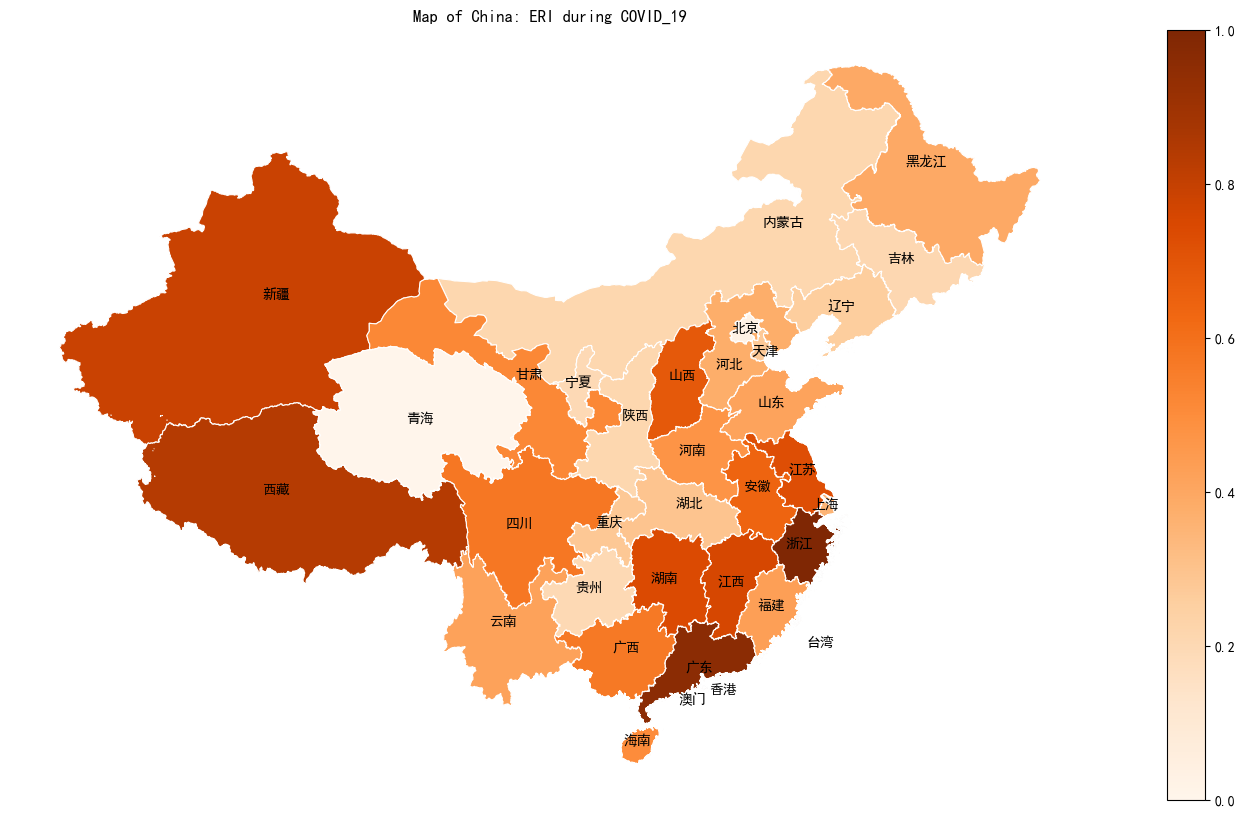

In [7]:
# --- 10. Visualize ERI on the China map ---
temp = pd.merge(gdf, eri_avg, on='Region', how='inner')
gdf['label_pos'] = gdf['geometry'].apply(lambda x: [* x.representative_point().coords[0]])

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.axis('off')
ax.set_title('Map of China: ERI during COVID_19')

# Plot provinces colored by ERI
temp.plot(
    column='ERI_norm', 
    cmap='Oranges', 
    linewidth=0.8,
    edgecolor="white",
    alpha=1, 
    legend=True, 
    ax=ax
)

# Offset labels for some provinces
offsets = {
    '河北': (-3, -16),    
    '天津': (3, -8),   
    '北京': (-3, -3),
    '香港': (11, -9),
    '澳门': (-6, -12),
    '台湾': (-5, -13) 
}

gdf.apply(lambda x: ax.annotate(
    text=x['Region'], 
    xy=x['label_pos'], 
    xytext=offsets.get(x['Region'], (0, 0)), 
    textcoords='offset points',
    ha='center'
), axis=1)

# Special annotation for Taiwan
taiwan_coords = [121.5091, 25.0443]  # lon, lat
ax.annotate('台湾', xy=taiwan_coords, xytext=offsets['台湾'], textcoords='offset points', ha='center')

# Save map ERI
plt.savefig("C:/Users/Bekzhan/Desktop/Economic_Resilience-China/data/visuals/maps/map_eri-covid.png", dpi=300, bbox_inches='tight')

plt.show()

In [8]:
# --- 11. Load sectoral structure data (Primary, Secondary, Tertiary industries) ---

# Read sectoral data 
pri = pd.read_excel("C:/Users/Bekzhan/Desktop/三次产业.xlsx", sheet_name="第一产业")
pri.to_csv("C:/Users/Bekzhan/Desktop/三次产业.csv", encoding="utf-8-sig")
sec = pd.read_excel("C:/Users/Bekzhan/Desktop/三次产业.xlsx", sheet_name="第二产业")
sec.to_csv("C:/Users/Bekzhan/Desktop/三次产业.csv", encoding="utf-8-sig")
tre = pd.read_excel("C:/Users/Bekzhan/Desktop/三次产业.xlsx", sheet_name="第三产业")
tre.to_csv("C:/Users/Bekzhan/Desktop/三次产业.csv", encoding="utf-8-sig")

# --- 12. Convert sectoral data to long format ---
pri = pri.melt(id_vars='Year', var_name='Region', value_name='Primary')
sec = sec.melt(id_vars='Year', var_name='Region', value_name='Secondary')
tre = tre.melt(id_vars='Year', var_name='Region', value_name='Tertiary')

pri = pri.sort_values(by=['Year', 'Region']).set_index(['Region', 'Year'])
sec = sec.sort_values(by=['Year', 'Region']).set_index(['Region', 'Year'])
tre = tre.sort_values(by=['Year', 'Region']).set_index(['Region', 'Year'])

# --- 13. Merge all sectoral indicators into one DataFrame ---
sect = pd.concat([pri, sec, tre], axis=1, join='inner').dropna()

# Filter years of interest and re-index
sect = sect.reset_index()
sect = sect[sect['Year'].isin(np.arange(2019, 2022))].sort_values(['Year']).set_index(['Region', 'Year'])

df = df.reset_index()
df = df[df['Year'].isin(np.arange(2019, 2022))].sort_values(['Year']).set_index(['Region', 'Year'])

# --- 14. Recalculate ERI using Z-score standardization (2019-2021)---
indicators = {
    'GDP_Gr': 1, 
    'Invest': 1, 
    'Insur_gr': 1, 
    'Unemp_gr': -1, 
    'Export': 1
}

for col, sign in indicators.items():
    df[f"z_{col}"] = zscore(df[col]) * sign

df['ERI'] = df[[f'z_{col}' for col in indicators.keys()]].mean(axis=1)

sect['ERI'] = df['ERI']

The trend line summarizes the overall relationship between the primary sector share and ERI. The spread of points around the line highlights differences in regional resilience that go beyond sectoral composition.

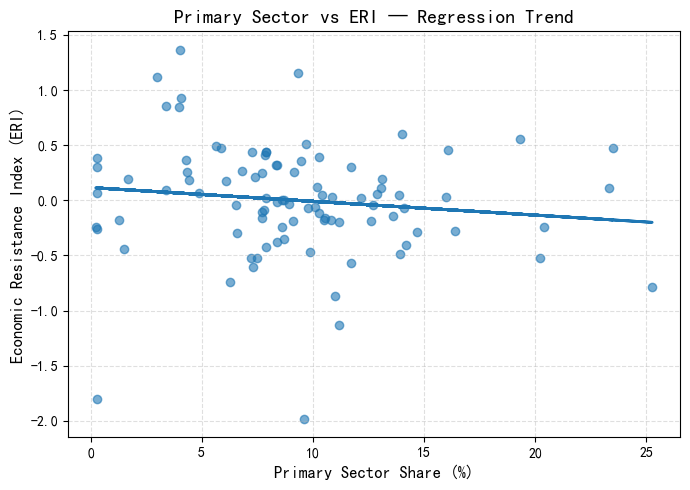

In [9]:
# --- 17. Relationship between sectoral structure and economic resilience ---
# Analyze how the share of the Primary sector relates to ERI

# Independent variable: share of the Primary sector
x = sect["Primary"]

# Dependent variable: Economic Resistance Index (ERI)
y = sect["ERI"]

# --- 18. Fit a simple linear regression (y = a*x + b) ---
# np.polyfit returns coefficients of the best-fit line
coef = np.polyfit(x, y, 1)

# Create a polynomial function from the coefficients
poly_fn = np.poly1d(coef)

# --- 19. Visualization: scatter plot with regression line ---
plt.figure(figsize=(7, 5))

# Scatter plot: each point represents a region-year observation
plt.scatter(x, y, alpha=0.6)

# Regression (trend) line
plt.plot(x, poly_fn(x), linewidth=2)

# --- 20. Plot styling ---
plt.title("Primary Sector vs ERI — Regression Trend", fontsize=14)
plt.xlabel("Primary Sector Share (%)", fontsize=12)
plt.ylabel("Economic Resistance Index (ERI)", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()

# Save plot
plt.savefig("C:/Users/Bekzhan/Desktop/Economic_Resilience-China/data/visuals/plots/plot-1.png", dpi=300, bbox_inches='tight')
plt.show()

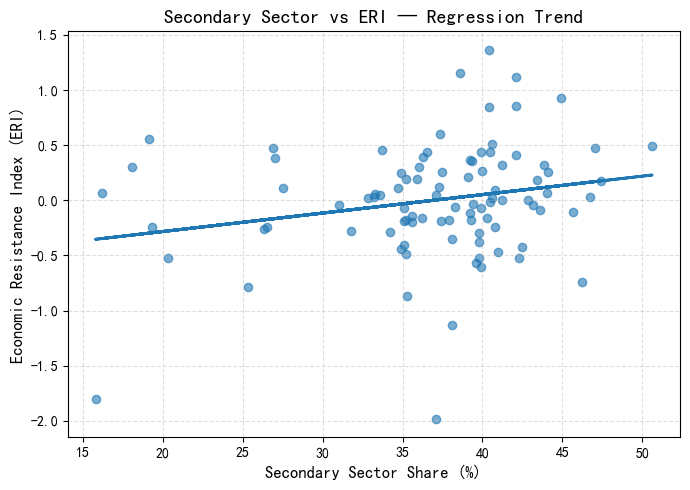

In [10]:
x = sect["Secondary"]
y = sect["ERI"]

coef = np.polyfit(x, y, 1)
poly_fn = np.poly1d(coef)

plt.figure(figsize=(7, 5))

plt.scatter(x, y, alpha=0.6)

plt.plot(x, poly_fn(x), linewidth=2)

plt.title("Secondary Sector vs ERI — Regression Trend", fontsize=14)
plt.xlabel("Secondary Sector Share (%)", fontsize=12)
plt.ylabel("Economic Resistance Index (ERI)", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()

plt.savefig("C:/Users/Bekzhan/Desktop/Economic_Resilience-China/data/visuals/plots/plot-2.png", dpi=300, bbox_inches='tight')
plt.show()

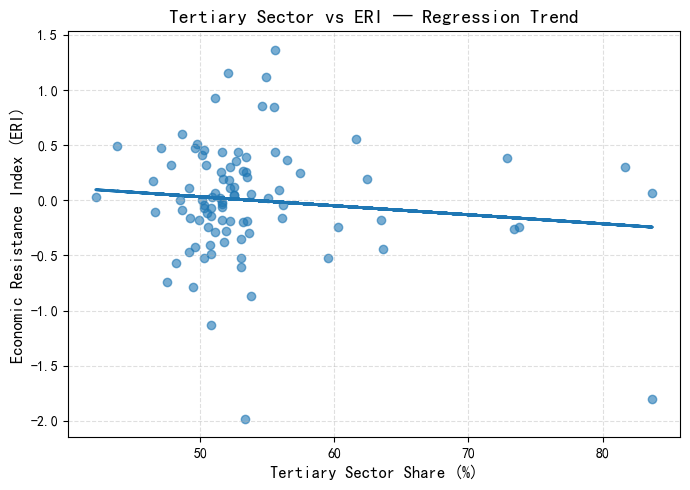

In [11]:
x = sect["Tertiary"]
y = sect["ERI"]

coef = np.polyfit(x, y, 1)
poly_fn = np.poly1d(coef)

plt.figure(figsize=(7, 5))

plt.scatter(x, y, alpha=0.6)

plt.plot(x, poly_fn(x), linewidth=2)

plt.title("Tertiary Sector vs ERI — Regression Trend", fontsize=14)
plt.xlabel("Tertiary Sector Share (%)", fontsize=12)
plt.ylabel("Economic Resistance Index (ERI)", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()

plt.savefig("C:/Users/Bekzhan/Desktop/Economic_Resilience-China/data/visuals/plots/plot-3.png", dpi=300, bbox_inches='tight')
plt.show()